In [1]:
import os
import time
from meidic_vtach_utils.run_on_recommended_cuda import get_cuda_environ_vars as get_vars
os.environ.update(get_vars(select="* -3 -4"))

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda.amp as amp

from IPython.display import display
import nibabel as nib
from torch.utils.checkpoint import checkpoint

from sklearn.model_selection import KFold

from mdl_seg_class.metrics import dice3d, dice2d
from mdl_seg_class.visualization import get_overlay_grid
from curriculum_deeplab.mindssc import mindssc

import curriculum_deeplab.ml_data_parameters_utils as ml_data_parameters_utils
import wandb
import random
import glob
import re
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np

print(torch.__version__)
print(torch.backends.cudnn.version())
print(torch.cuda.get_device_name(0))


### Recommended gpus on this machine (descending order) ###
  ID  Card name              Util    Mem free  Cuda             User(s)
----  -------------------  ------  ----------  ---------------  ---------
   0  Tesla T4                0 %   15109 MiB  11.1(455.45.01)
   1  Tesla T4                0 %   11687 MiB  11.1(455.45.01)  graf
   2  GeForce RTX 2080 Ti     0 %    6313 MiB  11.1(455.45.01)  graf
   3  Quadro RTX 8000         0 %    3001 MiB  11.1(455.45.01)  falta
   6  GeForce RTX 2080 Ti     1 %   11019 MiB  11.1(455.45.01)
   4  GeForce RTX 2080 Ti    56 %    1289 MiB  11.1(455.45.01)  falta
   5  GeForce RTX 2080 Ti  ! 99 %    6625 MiB  11.1(455.45.01)  weihsbach

Will apply following mapping

  ID  Card name        torch
----  -----------  --  -------
   0  Tesla T4     ->  cuda:0
1.9.1+cu102
7605
Tesla T4


In [2]:
class ASPPConv(nn.Sequential):
    def __init__(self, in_channels, out_channels, dilation):
        modules = [
            nn.Conv3d(in_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU()
        ]
        super(ASPPConv, self).__init__(*modules)


class ASPPPooling(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super(ASPPPooling, self).__init__(
            # nn.AdaptiveAvgPool2d(1),
            nn.Conv3d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU())

    def forward(self, x):
        size = x.shape[-3:]
        # x = F.adaptive_avg_pool3d(x, (1))
        for mod in self:
            x = mod(x)
        return F.interpolate(x, size=size, mode='nearest')  # , align_corners=False)


class ASPP(nn.Module):
    def __init__(self, in_channels, atrous_rates, out_channels=256):
        super(ASPP, self).__init__()
        modules = [nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU())]

        rates = tuple(atrous_rates)
        for rate in rates:
            modules.append(ASPPConv(in_channels, out_channels, rate))

        modules.append(ASPPPooling(in_channels, out_channels))

        self.convs = nn.ModuleList(modules)
 
        self.project = nn.Sequential(
            nn.Conv3d(len(self.convs) * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5))

    def forward(self, x):
        res = []
        for conv in self.convs:
            res.append(conv(x))
        res = torch.cat(res, dim=1)
        return self.project(res)


# Mobile-Net with depth-separable convolutions and residual connections
class ResBlock(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, inputs):
        return self.module(inputs) + inputs


def create_model(output_classes: int = 14,input_channels: int = 1):
    # in_channels = torch.Tensor([1,16,24,24,32,32,32,64]).long()
    in_channels = torch.Tensor([input_channels, 24, 24, 32, 48, 48, 48, 64]).long()
    mid_channels = torch.Tensor([64, 128, 192, 192, 256, 256, 256, 384]).long()
    out_channels = torch.Tensor([24, 24, 32, 48, 48, 48, 64, 64]).long()
    mid_stride = torch.Tensor([1, 1, 1, 2, 1, 1, 1, 1])
    net = [nn.Identity()]
    for i in range(8):
        inc = int(in_channels[i])
        midc = int(mid_channels[i])
        outc = int(out_channels[i])
        strd = int(mid_stride[i])
        layer = nn.Sequential(nn.Conv3d(inc, midc, 1, bias=False), nn.BatchNorm3d(midc), nn.ReLU6(True),
                              nn.Conv3d(midc, midc, 3, stride=strd, padding=1, bias=False, groups=midc),
                              nn.BatchNorm3d(midc), nn.ReLU6(True),
                              nn.Conv3d(midc, outc, 1, bias=False), nn.BatchNorm3d(outc))
        if i == 0:
            layer[0] = nn.Conv3d(inc, midc, 3, padding=1, stride=2, bias=False)
        if (inc == outc) & (strd == 1):
            net.append(ResBlock(layer))
        else:
            net.append(layer)

    backbone = nn.Sequential(*net)

    count = 0
    # weight initialization
    for m in backbone.modules():
        if isinstance(m, nn.Conv3d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out')
            count += 1
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, (nn.BatchNorm3d, nn.GroupNorm)):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.zeros_(m.bias)

    print('#CNN layer', count)
    # complete model: MobileNet + ASPP + head (with a single skip connection)
    # newer model (one more stride, no groups in head)
    aspp = ASPP(64, (2, 4, 8, 16, 32), 128)
    head = nn.Sequential(nn.Conv3d(128 + 24, 64, 1, padding=0, groups=1, bias=False), nn.BatchNorm3d(64), nn.ReLU(), \
                         nn.Conv3d(64, 64, 3, groups=1, padding=1, bias=False), nn.BatchNorm3d(64), nn.ReLU(), \
                         nn.Conv3d(64, output_classes, 1))
    return backbone, aspp, head


def apply_model(backbone, aspp, head, img, checkpointing=True, return_intermediate=False):
    if checkpointing:
        x1 = checkpoint(backbone[:3], img)
        x2 = checkpoint(backbone[3:], x1)
        y = checkpoint(aspp, x2)
        y1 = torch.cat((x1, F.interpolate(y, scale_factor=2)), 1)
        output_j = checkpoint(head, y1)
    else:
        x1 = backbone[:3](img)
        x2 = backbone[3:](x1)
        y = aspp(x2)
        y1 = torch.cat((x1, F.interpolate(y, scale_factor=2)), 1)
        output_j = head(y1)
    if return_intermediate:
        return y1,output_j
    else:
        return output_j


In [3]:
from pathlib import Path

class CrossMoDa_Data(Dataset):
    def __init__(self,
        base_dir, domain, state,
        ensure_labeled_pairs=True, use_additional_data=False, resample=True,
        size:tuple=(96,96,60), normalize:bool=True, max_load_num=None):
        """
        Function to create Dataset structure with crossMoDa data.
        The function allows to use different preproccessing steps of the crossMoDa data set
        and using additinal data from TCIA database.
        The data can also be resampled to a desired size and normalized to mean=0 and std=1.

        Parameters:
                base_dir (os.Pathlike): provide the directory which contains "L1..." to "L4..." directories
                domain (str): choose which domain to load. Can be set to "source", "target" or "validation". Source are ceT1, target and validation hrT2 images.

                state (str): state of preprocessing:    "l1" = original data,
                                                        "l2" = resampled data @ 0.5mm,
                                                        "l3" = center-cropped data,
                                                        "l4" = image specific crops for desired anatomy

                ensure_labeled_pairs (bool): Only images with corresponding labels will be loaded (default: True)
                
                use_additional_data (bool): set to True to use additional data from TCIA (default: False)

                resample (bool): set to False to disable resampling to desired size (default: True)

                size (tuple): 3d-tuple(int) to which the data is resampled. Unused if resample=False. (default: (96,96,60)).
                    WARNING: choosing large sizes or not resampling can lead to excess memory usage

                normalize (bool): set to False to disable normalization to mean=0, std=1 for each image (default: True)
                max_load_num (int): maximum number of pairs to load (uses first max_load_num samples for either images and labels found)
        Returns:
                torch.utils.data.Dataset containing CrossMoDa data

        Useful Links:
        CrossMoDa challenge:
        https://crossmoda.grand-challenge.org/

        ToDos:
            extend to other preprocessing states

        Example:
            dataset = CrossMoDa_source('original')

            data = dataset.get_data()

        """

        #define finished preprocessing states here with subpath and default size
        states = {
            'l1':('L1_original/', (512,512,160)),
            'l2':('L2_resampled_05mm/', (420,420,360)),
            'l3':('L3_coarse_fixed_crop/', (128,128,192)),
            'l4':('L4_fine_localized_crop/', (128,128,128))
        }
        
        t0 = time.time()
        #choose directory with data according to chosen preprocessing state
        if state not in states: raise Exception("Unknown state. Choose one of: "+str(states.keys))
        
        state_dir = states[state.lower()][0] #get sub directory
        
        if not resample: size = states[state.lower()][1] #set size to default defined at top of file
        
        path = base_dir + state_dir
        
        #get file list
        if domain.lower() =="ceT1" or domain.lower() =="source":
            directory = "source_training_labeled/"
            add_directory = "__additional_data_source_domain__"
            domain = "ceT1"
            
        elif domain.lower() =="hrT2" or domain.lower() =="target":
            directory = "target_training_unlabeled/"
            add_directory = "__additional_data_target_domain__"
            domain = "hrT2"
            
        elif domain.lower() =="validation":
            directory = "target_validation_unlabeled/"
            
        else:
            raise Exception("Unknown domain. Choose either 'source', 'target' or 'validation'")
        
        files = sorted(glob.glob(os.path.join(path+directory , "*.nii.gz")))

        if domain == "hrT2":
            files = files+sorted(glob.glob(os.path.join(path+"__omitted_labels_target_training__" , "*.nii.gz")))
        
        if domain.lower() == "validation":
            files = files+sorted(glob.glob(os.path.join(path+"__omitted_labels_target_validation__" , "*.nii.gz")))
        
        if use_additional_data and domain.lower() != "validation": #add additional data to file list
            files = files+sorted(glob.glob(os.path.join(path+add_directory , "*.nii.gz")))
            files = [i for i in files if "additionalLabel" not in i] #remove additional label files

        # First read filepaths
        self.img_paths = {}
        self.label_paths = {}
        
        for _path in files:
            numeric_id = int(re.findall(r'\d+', os.path.basename(_path))[0])
            if "_l.nii.gz" in _path or "_l_Label.nii.gz" in _path:
                lr_id = 'l'
            elif "_r.nii.gz" in _path or "_r_Label.nii.gz" in _path:
                lr_id = 'r'
            else:
                lr_id = ""

            if "Label" in _path:
                self.label_paths[str(numeric_id) + lr_id] = _path
                    
            elif domain in _path:
                self.img_paths[str(numeric_id) + lr_id] = _path
        
        if ensure_labeled_pairs:
            pair_idxs = set(self.img_paths).intersection(set(self.label_paths))
            if max_load_num:
                pair_idxs = list(pair_idxs)[:max_load_num]
            self.label_paths = {_id: _path for _id, _path in self.label_paths.items() if _id in pair_idxs}
            self.img_paths = {_id: _path for _id, _path in self.img_paths.items() if _id in pair_idxs}
        
        elif max_load_num:
            cut_img_idxs = list(self.img_paths.keys())[:max_load_num]
            cut_label_idxs = list(self.label_paths.keys())[:max_load_num]
            self.label_paths = {_id: _path for _id, _path in self.label_paths.items() if _id in cut_label_idxs}
            self.img_paths = {_id: _path for _id, _path in self.img_paths.items() if _id in cut_img_idxs}
            
        # Populate data
        self.img_data = {}
        self.label_data = {}
        
        #load data
        
        print("Loading CrossMoDa {} images and labels...".format(domain))
        id_paths_to_load = list(self.label_paths.items()) + list(self.img_paths.items())
        
        description = f"{len(self.img_paths)} images, {len(self.label_paths)} labels"
        
        for crossmoda_id, f in tqdm(id_paths_to_load, desc=description):
            # tqdm.write(f"Loading {f}")
            if "Label" in f:
                tmp = torch.from_numpy(nib.load(f).get_fdata())
                if resample: #resample image to specified size
                    tmp = F.interpolate(tmp.unsqueeze(0).unsqueeze(0), size=size,mode='nearest').squeeze()
                if tmp.shape != size: #for size missmatch use symmetric padding with 0
                    difs = [size[0]-tmp.size(0),size[1]-tmp.size(1),size[2]-tmp.size(2)]
                    pad = (difs[-1]//2,difs[-1]-difs[-1]//2,difs[-2]//2,difs[-2]-difs[-2]//2,difs[-3]//2,difs[-3]-difs[-3]//2)
                    tmp = F.pad(tmp,pad)
                    
                self.label_data[crossmoda_id] = tmp.long()
                    
            elif domain in f:
                tmp = torch.from_numpy(nib.load(f).get_fdata())
                if resample: #resample image to specified size
                    tmp = F.interpolate(tmp.unsqueeze(0).unsqueeze(0), size=size,mode='trilinear',align_corners=False).squeeze()
                
                if normalize: #normalize image to zero mean and unit std
                    tmp = (tmp - tmp.mean()) / tmp.std()
                
                if tmp.shape != size: #for size missmatch use symmetric padding with 0
                    difs = [size[0]-tmp.size(0),size[1]-tmp.size(1),size[2]-tmp.size(2)]
                    pad = (difs[-1]//2,difs[-1]-difs[-1]//2,difs[-2]//2,difs[-2]-difs[-2]//2,difs[-3]//2,difs[-3]-difs[-3]//2)
                    tmp = F.pad(tmp,pad)
                    
                self.img_data[crossmoda_id] = tmp
        
        #check for consistency
        print("Equal image and label numbers: {}".format(set(self.img_data)==set(self.label_data)))
        
        img_stack = torch.stack(list(self.img_data.values()), dim=0)
        img_mean, img_std = img_stack.mean(), img_stack.std()
        
        label_stack = torch.stack(list(self.label_data.values()), dim=0)

        print("Image shape: {}, mean.: {:.2f}, std.: {:.2f}".format(img_stack.shape, img_mean, img_std))
        print("Label shape: {}, max.: {}".format(label_stack.shape,torch.max(label_stack)))
        print("Data import finished. Elapsed time: {:.1f} s".format(time.time()-t0 ))

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, dataset_idx):
        map_crossmoda_idx_from_continuos = list(self.img_data.keys())
        c_idx = map_crossmoda_idx_from_continuos[dataset_idx]
        
        image = self.img_data.get(c_idx, torch.tensor([]))
        label = self.label_data.get(c_idx, torch.tensor([]))
        image_path = self.img_paths.get(c_idx, "")
        label_path = self.label_paths.get(c_idx, "")
        
        return image, label, dataset_idx, c_idx, image_path, label_path

    def get_data(self):
        img_stack = torch.stack(list(self.img_data.values()), dim=0)
        label_stack = torch.stack(list(self.label_data.values()), dim=0)
        
        return img_stack, label_stack

In [4]:
#training routine
def display_nonempty_seg_slices(img_slices, seg_slices, alpha=.5):
    assert img_slices.dim() == 4, "Image slices need to have dimensions SxCxHxW"
    assert seg_slices.dim() == 3, "Segmentation slices need to have dimensions SxHxW"
    
    color_map = {
        0: None, 
        1: (255,0,0), #ONEHOT id and RGB color
        2: (0,255,0)
    }

    idx_dept_with_segs, *_ = torch.nonzero(seg_slices > 0, as_tuple=True)
    
    if idx_dept_with_segs.nelement() > 0:
        idx_dept_with_segs = idx_dept_with_segs.unique()

        img_slices = img_slices[idx_dept_with_segs]
        seg_slices = seg_slices[idx_dept_with_segs]

        pil_ov, _ = get_overlay_grid(
            img_slices, 
            torch.nn.functional.one_hot(seg_slices, 3), 
            color_map, n_per_row=10, alpha=alpha
        )
        display(pil_ov)
    else:
        print("No empty slices to display.")

In [5]:
training_dataset = CrossMoDa_Data("/share/data_supergrover1/weihsbach/shared_data/tmp/CrossMoDa/", 
    domain="source", state="l4", ensure_labeled_pairs=True, max_load_num=100)
validation_dataset = CrossMoDa_Data("/share/data_supergrover1/weihsbach/shared_data/tmp/CrossMoDa/", 
    domain="validation", state="l4", ensure_labeled_pairs=True)
# target_dataset = CrossMoDa_Data("/share/data_supergrover1/weihsbach/shared_data/tmp/CrossMoDa/", 
#     domain="target", state="l4", ensure_labeled_pairs=True)

Loading CrossMoDa ceT1 images and labels...


100 images, 100 labels: 100%|█████████████████| 200/200 [00:13<00:00, 14.54it/s]


Equal image and label numbers: True
Image shape: torch.Size([100, 96, 96, 60]), mean.: 0.00, std.: 1.00
Label shape: torch.Size([100, 96, 96, 60]), max.: 2
Data import finished. Elapsed time: 14.4 s
Loading CrossMoDa validation images and labels...


19 images, 19 labels: 100%|█████████████████████| 38/38 [00:02<00:00, 15.81it/s]


Equal image and label numbers: True
Image shape: torch.Size([19, 96, 96, 60]), mean.: -0.00, std.: 1.00
Label shape: torch.Size([19, 96, 96, 60]), max.: 2
Data import finished. Elapsed time: 2.5 s


Sample 43:
With ground-truth overlay


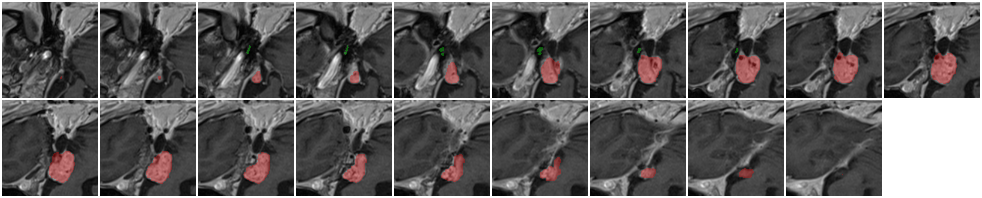

W/o ground-truth overlay


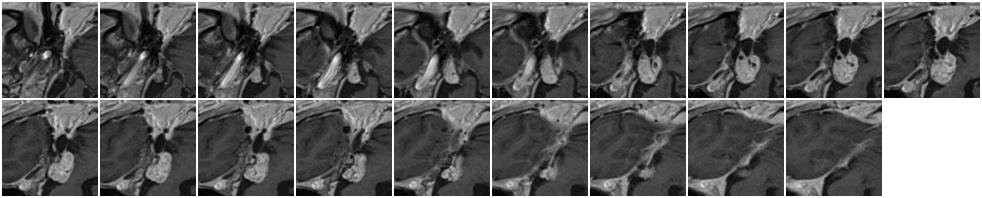

Sample 55:
With ground-truth overlay


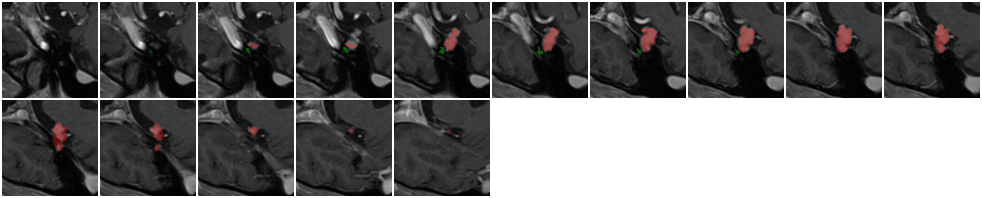

W/o ground-truth overlay


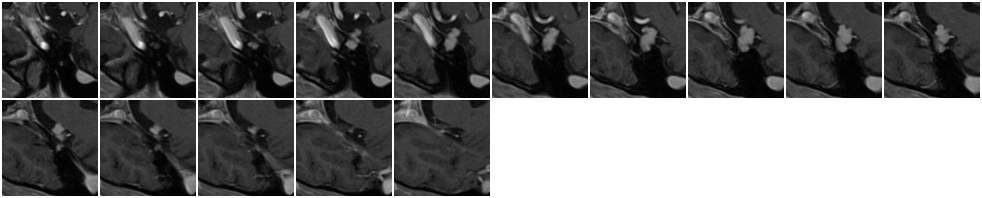

Sample 81:
With ground-truth overlay


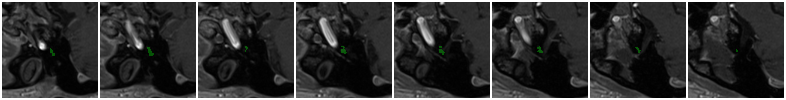

W/o ground-truth overlay


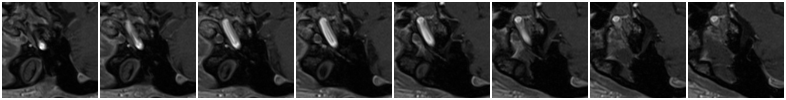

Sample 87:
With ground-truth overlay


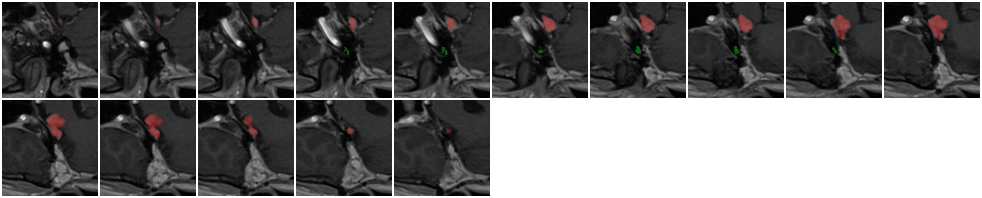

W/o ground-truth overlay


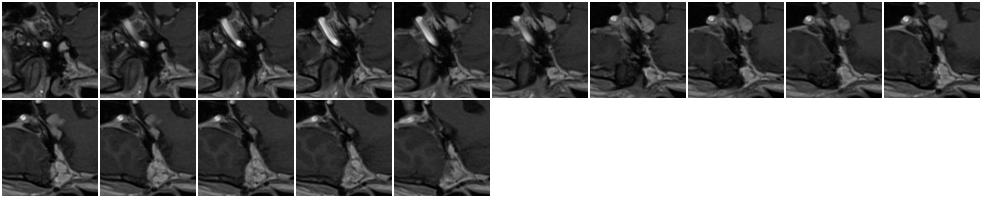

Sample 63:
With ground-truth overlay


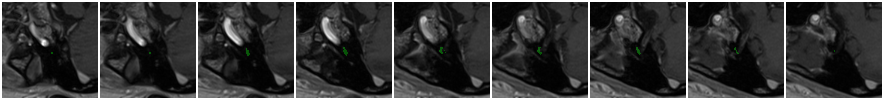

W/o ground-truth overlay


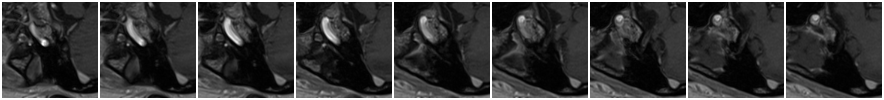

In [6]:
# train_subset = torch.utils.data.Subset(training_dataset,range(2))
train_subset = [training_dataset[idx] for idx in (43, 55, 81, 87, 63)]
for img, seg, sample_idx, *_ in train_subset:
    print(f"Sample {sample_idx}:")
    img_slices = img.permute(2,0,1).unsqueeze(1)
    seg_slices = seg.permute(2,0,1)
    print("With ground-truth overlay")
    display_nonempty_seg_slices(img_slices, seg_slices, alpha=.3)

    print("W/o ground-truth overlay")
    display_nonempty_seg_slices(img_slices, seg_slices, alpha=.0)

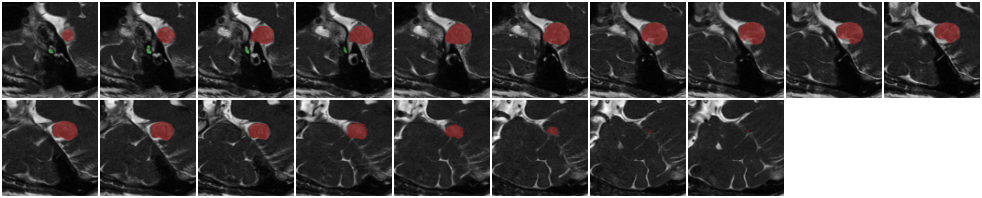

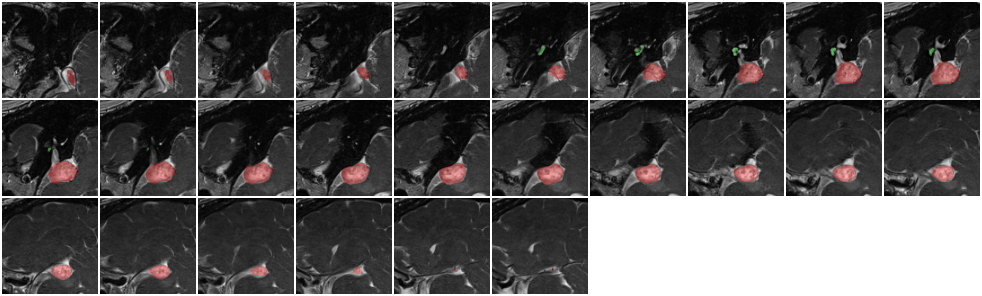

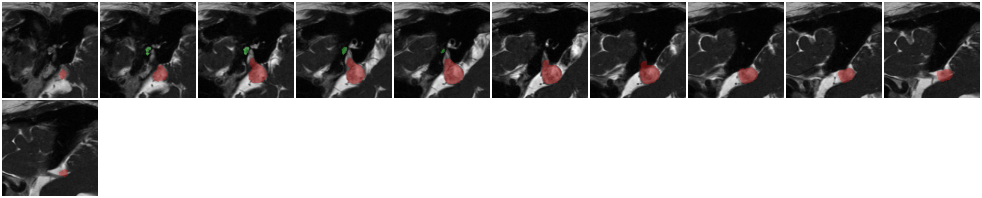

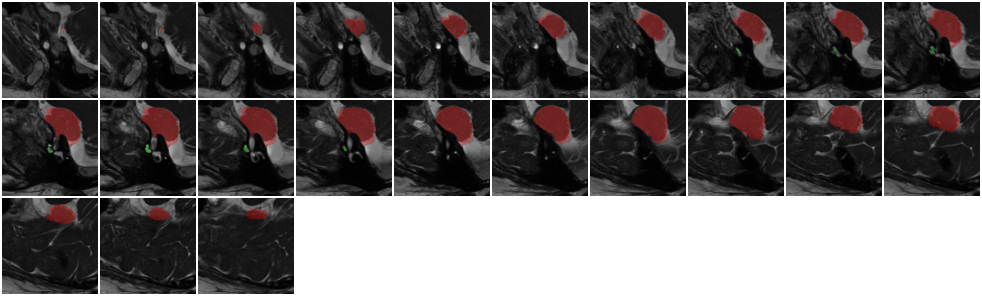

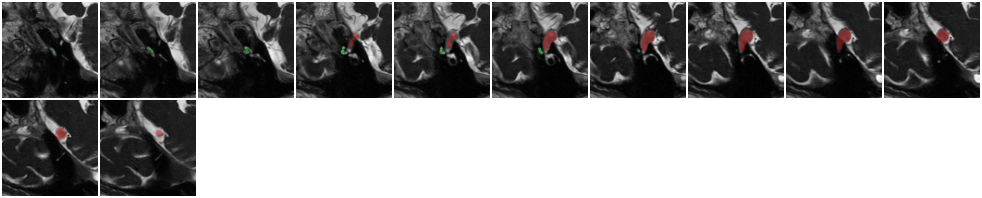

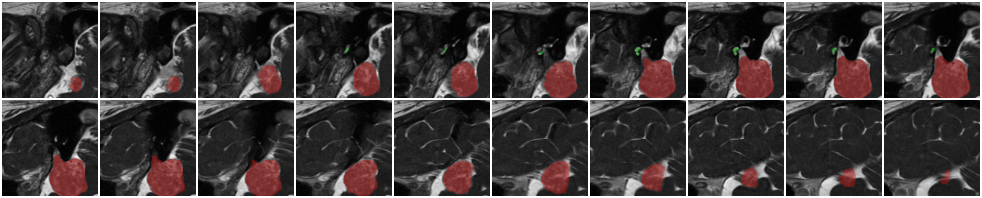

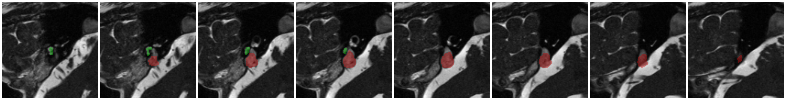

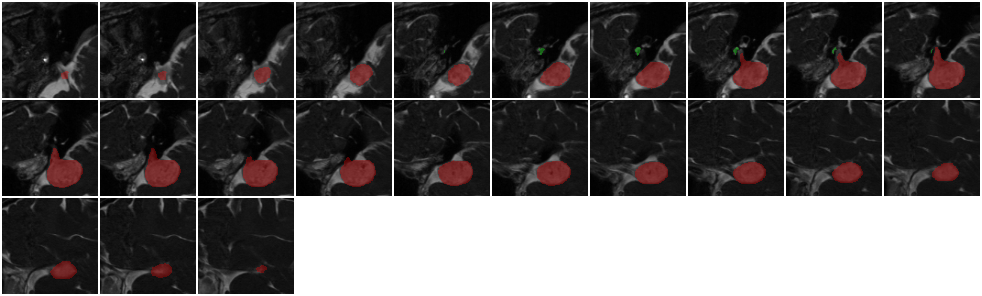

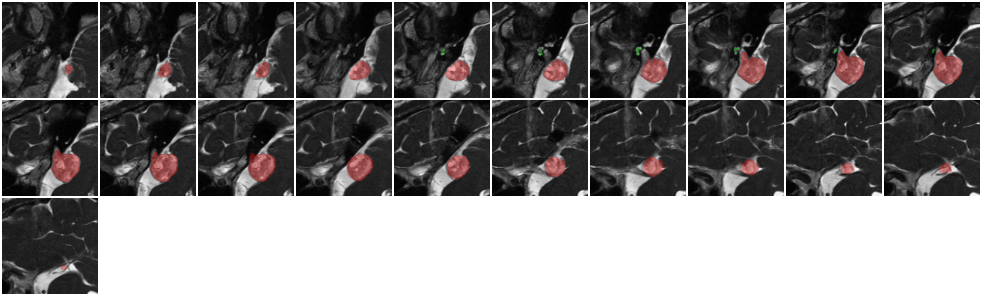

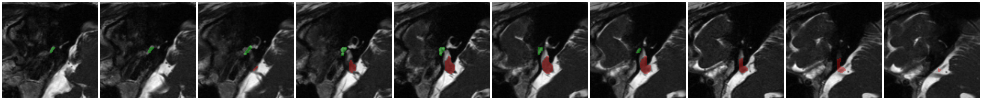

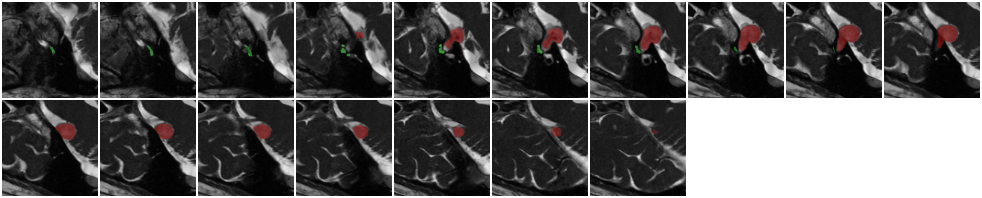

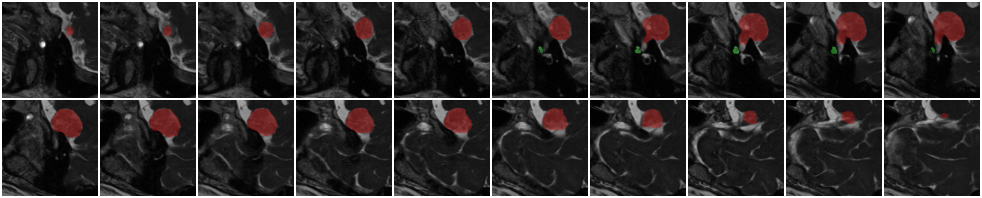

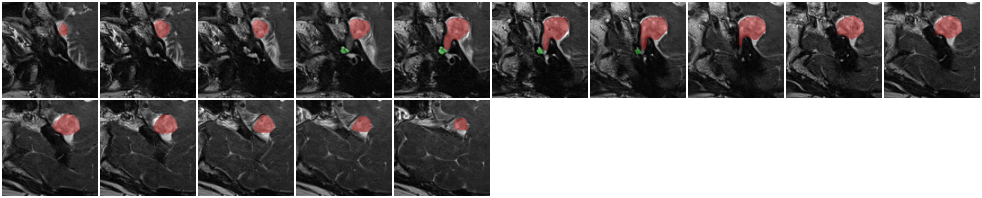

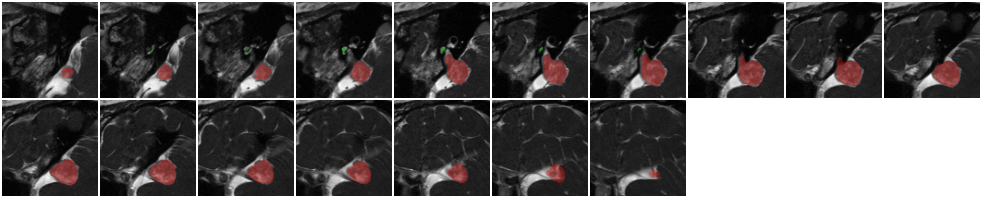

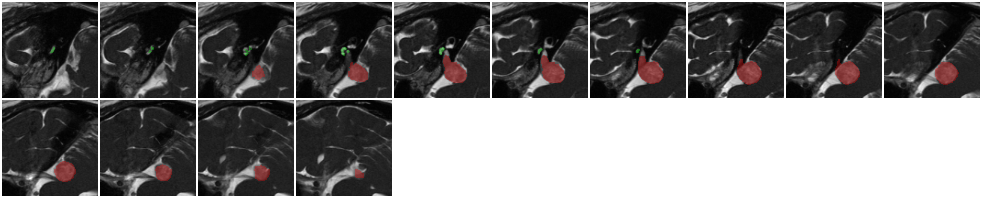

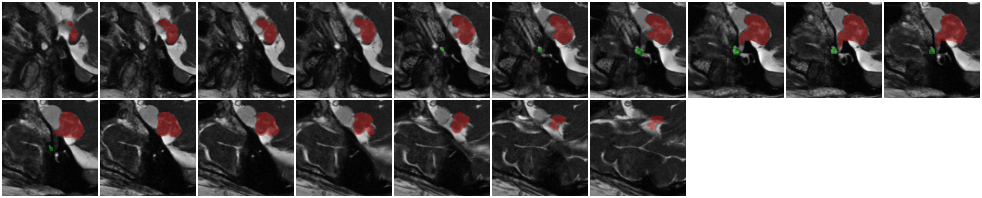

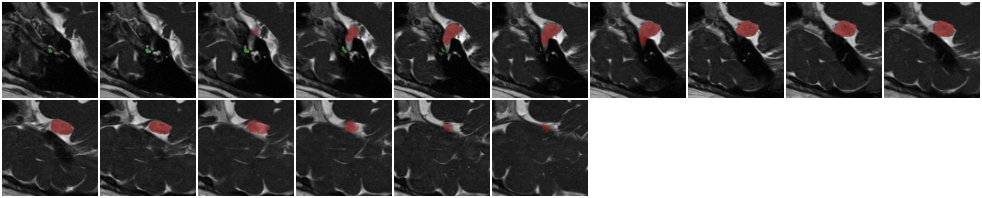

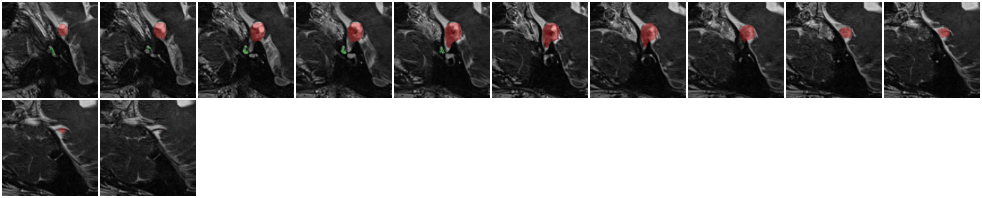

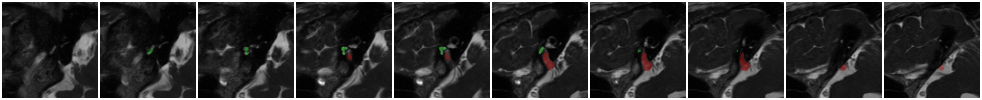

In [7]:
for img, seg, *_ in validation_dataset:
    img_slices = img.permute(2,0,1).unsqueeze(1)
    seg_slices = seg.permute(2,0,1)
    display_nonempty_seg_slices(img_slices, seg_slices, alpha=.3)
    # display_nonempty_seg_slices(img_slices, seg_slices, alpha=.0)

In [8]:
# Readd when target dataset is used
# img, seg, _ = target_dataset[30]
# img_slices = img.permute(2,0,1).unsqueeze(1)
# seg_slices = seg.permute(2,0,1)
# display_nonempty_seg_slices(img_slices, seg_slices, alpha=.3)
# display_nonempty_seg_slices(img_slices, seg_slices, alpha=.0)

In [9]:
def augmentAffine(img_in, seg_in, strength=0.05):
    """
    3D affine augmentation on image and segmentation mini-batch on GPU.
    (affine transf. is centered: trilinear interpolation and zero-padding used for sampling)
    :input: img_in batch (torch.cuda.FloatTensor), seg_in batch (torch.cuda.LongTensor)
    :return: augmented BxCxTxHxW image batch (torch.cuda.FloatTensor), augmented BxTxHxW seg batch (torch.cuda.LongTensor)
    """
    B,C,D,H,W = img_in.size()
    affine_matrix = (torch.eye(3,4).unsqueeze(0) + torch.randn(B, 3, 4) * strength).to(img_in.device)

    meshgrid = F.affine_grid(affine_matrix,torch.Size((B,1,D,H,W)), align_corners=False)

    img_out = F.grid_sample(img_in, meshgrid, padding_mode='border')
    seg_out = F.grid_sample(seg_in.float(), meshgrid, mode='nearest')

    return img_out, seg_out.long()



def augmentNoise(img_in,strength=0.05):
    return img_in + strength*torch.randn_like(img_in)


In [10]:
def save_model(backbone, aspp, head, inst_parameters, class_parameters, 
    optimizer, optimizer_inst_param, optimizer_class_param, 
    scaler, name):
    
    torch.save(backbone.state_dict(), name + '_backbone.pth')
    torch.save(aspp.state_dict(), name + '_aspp.pth')
    torch.save(head.state_dict(), name + '_head.pth')
    
    torch.save(inst_parameters, name + '_inst_parameters.pth')
    torch.save(class_parameters, name + '_class_parameters.pth')
    
    torch.save(optimizer.state_dict(), name + '_optimizer.pth')
    torch.save(optimizer_inst_param.state_dict(), name + '_optimizer_inst_param.pth')
    torch.save(optimizer_class_param.state_dict(), name + '_optimizer_class_param.pth')
    
    torch.save(scaler.state_dict(), name + '_grad_scaler.pth')

def load_model(name, config, dataset_len):
    if config.use_mind:
        input_channels = 12
    else:
        input_channels = 1

    backbone, aspp, head = create_model(output_classes=config.num_classes, input_channels=input_channels)
    optimizer = torch.optim.Adam(
        list(backbone.parameters()) + list(aspp.parameters()) + list(head.parameters()),
        lr=config.lr
    )
    
    (_, _, optimizer_class_param, optimizer_inst_param) = \
        ml_data_parameters_utils.get_class_inst_data_params_n_optimizer(config,
            config.init_class_param, config.learn_class_parameters, config.lr_class_param,
            config.init_inst_param, config.learn_inst_parameters, config.lr_inst_param,
            nr_classes=config.num_classes,
            nr_instances=dataset_len,
            device='cuda'
        )
    
    scaler = amp.GradScaler()
    
    backbone.load_state_dict(torch.load(name + '_backbone.pth'))
    aspp.load_state_dict(torch.load(name + '_aspp.pth'))
    head.load_state_dict(torch.load(name + '_head.pth'))
    
    inst_parameters = torch.load(name + '_inst_parameters.pth')
    class_parameters = torch.load(name + '_class_parameters.pth')
    
    optimizer.load_state_dict(torch.load(name + '_optimizer.pth'))
    optimizer_inst_param.load_state_dict(torch.load(name + '_optimizer_inst_param.pth'))
    optimizer_class_param.load_state_dict(torch.load(name + '_optimizer_class_param.pth'))
    
    scaler.load_state_dict(torch.load(name + '_grad_scaler.pth'))
                                          
    return (backbone, aspp, head, inst_parameters, class_parameters, 
        optimizer, optimizer_inst_param, optimizer_class_param, 
        scaler)

In [11]:
def get_global_idx(fold_idx, epoch_idx, max_epochs):
    # Get global index e.g. 2250 for fold_idx=2, epoch_idx=250 @ max_epochs<1000
    return 10**len(str(int(max_epochs)))*fold_idx + epoch_idx
            
            
def log_n_largest_data_parameters(parameter_idxs, parameters, log_path, n=10):
    data = [[inst_idx, val] for (inst_idx, val) in \
        zip(parameter_idxs, torch.exp(parameters).tolist())]

    data.sort(key=lambda x: x[1], reverse=True)

    data = data[:n]
    table = wandb.Table(data=data, columns = ["parameter_idx", "value"])
    wandb.log({log_path : wandb.plot.bar(table, "parameter_idx", "value", title=log_path)})
    
def get_largest_data_parameters_in_target_ratio(parameter_idxs, parameters, target_idxs):
    # print("param_idxs", parameter_idxs)
    # print("parameters", parameters)
    # print("target_idxs", target_idxs)
    data = [[inst_idx, val] for (inst_idx, val) in \
        zip(parameter_idxs, torch.exp(parameters).tolist())]
    
    topk_cont_idxs = torch.argsort(parameters, descending=True)[:len(target_idxs)]
    # print("topk_cont_idxs", topk_cont_idxs)
    topk_dataset_idxs = parameter_idxs[topk_cont_idxs]
    # print("topk_dataset_idxs", topk_dataset_idxs)
    ratio = np.sum(np.in1d(topk_dataset_idxs, target_idxs))/len(target_idxs)
    
    return ratio
    
def reset_determinism():
    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)
    # torch.use_deterministic_algorithms(True)

In [12]:
def disturb_seg(seg):  
    return torch.flip(seg, dims=(-3,-2,-1))
    # disturbed = (
    #     seg.roll(np.random.randint(5,40), dims=-1)
    #     .roll(np.random.randint(5,40), dims=-2)
    #     .roll(np.random.randint(5,40), dims=-3)
    # )
    # return disturbed

def map_continuous_from_dataset_idxs(subset_to_map, dataset_idxs):
    cont_idxs = torch.tensor([torch.where(dataset_idxs==d_idx) for d_idx in subset_to_map]).reshape(subset_to_map.shape)
    return cont_idxs

def train_DL(run_name, config, training_dataset):
    reset_determinism()
    kf = KFold(n_splits=config.num_folds)
    kf.get_n_splits(training_dataset)
    
    fold_means_no_bg = []
    
    fold_iter = enumerate(kf.split(training_dataset))
    
    if config.only_first_fold:
        fold_iter = list(fold_iter)[0:1]
    dataset_info = [[d_idx, crossmoda_idx, img_path, label_path] for _, _, d_idx, crossmoda_idx, img_path, label_path in iter(training_dataset)]
    wandb.log({'datasets/training_dataset':wandb.Table(columns=['dataset_idx', 'crossmoda_idx', 'image', 'label'], data=dataset_info)}, step=0)
        
    for fold_idx, (train_idxs, val_idxs) in fold_iter:
        train_idxs = torch.tensor(train_idxs)
        val_idxs = torch.tensor(val_idxs)
        
        disturbed_idxs = np.random.choice(train_idxs, size=config.disturbed_flipped_num, replace=False)
        disturbed_idxs = torch.tensor(disturbed_idxs)
        
        clean_idxs = train_idxs[np.isin(train_idxs, disturbed_idxs, invert=True)]
        clean_idxs = torch.tensor(clean_idxs)
        
        wandb.log({f'datasets/disturbed_idxs_fold{fold_idx}':wandb.Table(columns=['train_idxs'], data=[[idx] for idx in disturbed_idxs])}, 
                  step=get_global_idx(fold_idx, 0, config.epochs))
        print("Will disturb these indexes:", sorted(disturbed_idxs.tolist()))
        print("Clean indexes are:", sorted(clean_idxs.tolist()))
        
        if config.do_plot:
            print("Disturbed samples:")
            for d_idx in disturbed_idxs:
                img_slices = training_dataset[d_idx][0].permute(2,0,1).unsqueeze(1)
                seg_slices = disturb_seg(training_dataset[d_idx][1]).permute(2,0,1).to(dtype=torch.int64)
                display_nonempty_seg_slices(img_slices, seg_slices)
                        
        if config.use_mind:
            C =12
        else:
            C = 1
        _, all_segs = training_dataset.get_data()

        class_weight = torch.sqrt(1.0/(torch.bincount(all_segs.long().view(-1)).float()))
        class_weight = class_weight/class_weight.mean()
        class_weight[0] = 0.15
        class_weight = class_weight.cuda()
        print('inv sqrt class_weight', class_weight)
        
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idxs)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idxs)

        train_dataloader = DataLoader(training_dataset, batch_size=config.batch_size, shuffle=False, sampler=train_subsampler, pin_memory=True)
        val_dataloader = DataLoader(training_dataset, batch_size=config.batch_size, shuffle=False, sampler=val_subsampler, pin_memory=True)

        backbone, aspp, head = create_model(output_classes=config.num_classes, input_channels=C)
        optimizer = torch.optim.Adam(list(backbone.parameters())+list(aspp.parameters())+list(head.parameters()),
            lr=config.lr)
        # optimizer = torch.optim.SGD(list(backbone.parameters())+list(aspp.parameters())+list(head.parameters(), config.lr, momentum=config.momentum)

        # Initialize class and instance based temperature
        (class_parameters, inst_parameters, optimizer_class_param, optimizer_inst_param) = \
            ml_data_parameters_utils.get_class_inst_data_params_n_optimizer(config,
                config.init_class_param, config.learn_class_parameters, config.lr_class_param,
                config.init_inst_param, config.learn_inst_parameters, config.lr_inst_param,
                nr_classes=config.num_classes,
                nr_instances=len(train_idxs),
                device='cuda'
            )

        # criterion = nn.CrossEntropyLoss(class_weight)
        criterion = nn.CrossEntropyLoss()
        scaler = amp.GradScaler()

        top1 = ml_data_parameters_utils.AverageMeter('Acc@1', ':6.2f')
        top5 = ml_data_parameters_utils.AverageMeter('Acc@5', ':6.2f')

        backbone.cuda() 
        backbone.train()
        aspp.cuda() 
        aspp.train()
        head.cuda() 
        head.train()
        t0 = time.time()

        for epx in range(config.epochs):
            global_idx = get_global_idx(fold_idx, epx, config.epochs)
            backbone.train()
            aspp.train()
            head.train()

            optimizer.zero_grad()
            if config.learn_class_parameters:
                optimizer_class_param.zero_grad()
            if config.learn_inst_parameters:
                optimizer_inst_param.zero_grad()

            # Load datta
            b_img, b_seg, b_idxs_dataset, *_ = next(iter(train_dataloader))
            
            do_disturb = epx > config.start_disturbing_after_ep
            wandb.log({"do_disturb": float(do_disturb)}, step=global_idx)
            
            if do_disturb:
                for batch_idx, seg_dataset_idx in enumerate(b_idxs_dataset):
                    # Add disturbance (flipping)
                    if seg_dataset_idx.item() in disturbed_idxs:
                        b_seg[batch_idx] = disturb_seg(b_seg[batch_idx])
                        if config.debug and config.do_plot:
                            dis_img_slices = b_img[batch_idx].permute(2,0,1).unsqueeze(1)
                            dis_seg_slices = b_seg[batch_idx].permute(2,0,1).to(dtype=torch.int64)
                            display_nonempty_seg_slices(dis_img_slices, dis_seg_slices)
                                
            b_img = b_img.unsqueeze(1)
            b_seg = b_seg.unsqueeze(1)

            b_img, b_seg = b_img.float().cuda(), b_seg.cuda()
            b_img, b_seg = augmentAffine(b_img, b_seg, strength=0.1)
            
            b_img = augmentNoise(b_img, strength=0.02)
            
            if config.use_mind:
                b_img = mindssc(b_img)

            b_interpolated_seg = F.interpolate(b_seg.float(), scale_factor=0.5, mode='nearest').long()
            b_interpolated_seg = b_interpolated_seg.squeeze(1)
            
            b_img.requires_grad = True
            
            #img_mr.requires_grad = True
            with amp.autocast(enabled=True):
                logits = apply_model(backbone, aspp, head, b_img, checkpointing=True)

                if config.learn_class_parameters or config.learn_inst_parameters:
                    # Compute data parameters for instances in the minibatch
                    class_parameter_minibatch = torch.tensor([0])
                    # class_parameter_minibatch = class_parameters[b_seg] TODO: Readd that again
                    cont_idxs = map_continuous_from_dataset_idxs(b_idxs_dataset, train_idxs)
                    inst_parameter_minibatch = inst_parameters[cont_idxs]
                    
                    data_parameter_minibatch = ml_data_parameters_utils.get_data_param_for_minibatch(
                                                    learn_class_parameters=config.learn_class_parameters, 
                                                    learn_inst_parameters=config.learn_inst_parameters,
                                                    class_param_minibatch=class_parameter_minibatch,
                                                    inst_param_minibatch=inst_parameter_minibatch)

                    # Compute logits scaled by data parameters
                    logits = logits / data_parameter_minibatch.view([-1] + [1]*(logits.dim()-1))
  
                loss = criterion(logits, b_interpolated_seg)
                # Apply weight decay on data parameters
                if config.learn_class_parameters or config.learn_inst_parameters:
                    loss = ml_data_parameters_utils.apply_weight_decay_data_parameters(
                        config.learn_inst_parameters, config.wd_inst_param,
                        config.learn_class_parameters, config.wd_class_param,
                        loss,
                        class_parameter_minibatch=class_parameter_minibatch,
                        inst_parameter_minibatch=inst_parameter_minibatch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)

            if config.learn_class_parameters:
                scaler.step(optimizer_class_param)
            if config.learn_inst_parameters:
                scaler.step(optimizer_inst_param)

            scaler.update()

            # Clamp class and instance level parameters within certain bounds
            if config.learn_class_parameters or config.learn_inst_parameters:
                ml_data_parameters_utils.clamp_data_parameters(
                    config.skip_clamp_data_param, config.learn_inst_parameters, config.learn_class_parameters,
                    class_parameters, inst_parameters,
                    config.clamp_inst_sigma_config, config.clamp_cls_sigma_config)

            # # Measure accuracy and record loss # TODO add again
            # acc1, acc5 = ml_data_parameters_utils.compute_topk_accuracy(logits, b_interpolated_seg, topk=(1, 1))
            # top1.update(acc1[0], b_img.size(0))
            # top5.update(acc5[0], b_img.size(0))
            
            if epx % config.log_every == 0 or (epx+1 == config.epochs):
                dice = dice3d(
                    torch.nn.functional.one_hot(logits.argmax(1), 3),
                    torch.nn.functional.one_hot(b_interpolated_seg, 3), one_hot_torch_style=True
                )
                # Log data disturbed parameters
                cont_idxs_disturbed = map_continuous_from_dataset_idxs(disturbed_idxs, train_idxs)
                ml_data_parameters_utils.log_intermediate_iteration_stats(
                    "data_parameters/disturbed/", f"_fold{fold_idx}",
                    global_idx,
                    config.learn_class_parameters, config.learn_inst_parameters,
                    class_parameters, inst_parameters[cont_idxs_disturbed], top1, top5)
                
                cont_idxs_clean = map_continuous_from_dataset_idxs(clean_idxs, train_idxs)
                ml_data_parameters_utils.log_intermediate_iteration_stats(
                    "data_parameters/clean/", f"_fold{fold_idx}",
                    global_idx,
                    config.learn_class_parameters, config.learn_inst_parameters,
                    class_parameters, inst_parameters[cont_idxs_clean], top1, top5)


                with amp.autocast(enabled=True):
                    backbone.eval()
                    aspp.eval()
                    head.eval()

                    with torch.no_grad():
                        b_val_img, b_val_seg, *_ = next(iter(val_dataloader))
                        
                        if config.do_plot:
                            print("Show val img/lbl input")
                            for val_img, val_seg in zip(b_val_img, b_val_seg):
                                val_img_slices = val_img.detach().permute(2,0,1).unsqueeze(1)
                                val_seg_slices = val_seg.detach().permute(2,0,1).to(dtype=torch.int64)
                                display_nonempty_seg_slices(val_img_slices, val_seg_slices)

                        b_val_img, b_val_seg = (
                            b_val_img.unsqueeze(1).float().cuda(), 
                            b_val_seg.unsqueeze(1).float().cuda()
                        )

                        if config.use_mind:
                            b_val_img = mindssc(b_val_img)

                        b_interpolated_val_seg = F.interpolate(b_val_seg, scale_factor=0.5, mode='nearest').long()
                        b_interpolated_val_seg = b_interpolated_val_seg.squeeze(1)
                        
                        output_val = apply_model(backbone, aspp, head, b_val_img, checkpointing=False)
                    
                        val_dice = dice3d(
                            torch.nn.functional.one_hot(output_val.argmax(1), 3),
                            torch.nn.functional.one_hot(b_interpolated_val_seg, 3), one_hot_torch_style=True
                        )

                        if config.do_plot:
                            print("Show val lbl/prediction")
                            for val_seg, pred_val_seg in zip(b_val_seg, output_val.argmax(1)):
                                val_seg = val_seg.squeeze(0).permute(2,0,1).unsqueeze(1)
                                pred_seg_slices = pred_val_seg.permute(2,0,1)
                                
                                pred_seg_slices = F.upsample_nearest(pred_seg_slices.unsqueeze(0).unsqueeze(0).float(), scale_factor=2).squeeze(0).squeeze(0).long()
                                display_nonempty_seg_slices(val_seg, pred_seg_slices)

                dice_mean_no_bg = round(dice.mean(dim=0)[1:].mean().item(),4)
                val_dice_mean_no_bg = round(val_dice.mean(dim=0)[1:].mean().item(),4)
                
                inst_param_ratio = get_largest_data_parameters_in_target_ratio(
                    train_idxs, inst_parameters, disturbed_idxs
                )
                
                print(
                    f'epx_fold{fold_idx}', epx, round(time.time()-t0,2),'s',
                    f'loss_fold{fold_idx}', round(loss.item(),6),
                    f'dice_tensor_fold{fold_idx}', dice, 
                    f'dice_mean_nobg_fold{fold_idx}', dice_mean_no_bg,
                    f'val_dice_mean_nobg_fold{fold_idx}', val_dice_mean_no_bg,
                    f'data_param_ratio_fold{fold_idx}', inst_param_ratio
                )
                # Log the epoch idx per fold - so you can recover the diagram by setting 
                # ref_epoch_idx as x-axis in wandb interface
                wandb.log({"ref_epoch_idx": epx}, step=global_idx)
                
                wandb.log({f'losses/loss_fold{fold_idx}': loss}, step=global_idx)
                # wandb.log({f'scores/dice_tensor': dice}, step=global_idx)
                # wandb.log({f'scores/val_dice_tensor': val_dice}, step=global_idx)
                wandb.log({f'scores/dice_mean_wo_bg_fold{fold_idx}': dice_mean_no_bg}, step=global_idx)
                wandb.log({f'scores/val_dice_mean_wo_bg_fold{fold_idx}': val_dice_mean_no_bg}, step=global_idx)
                wandb.log(
                    {f'data_parameters/inst_param_largest_in_target_ratio_fold{fold_idx}': inst_param_ratio}, 
                    step=global_idx
                )
                
                # print("Class parameters: ", class_parameters)
                # print("Instance parameters: ", inst_parameters)
            
            if config.debug:
                break
                
        # End of fold loop        
        log_n_largest_data_parameters(train_idxs, inst_parameters, 
            f"data_parameters/largest_instance_parameters_fold{fold_idx}", n=30
        )
        
        log_n_largest_data_parameters(train_idxs, inst_parameters, 
            f"data_parameters/all_instance_parameters_fold{fold_idx}", n=len(training_dataset)
        )
    
        # TODO log instance parameters and disturbed instance parameters here
        backbone.cpu()
        aspp.cpu() 
        head.cpu()
        
        save_model(backbone, aspp, head, inst_parameters, class_parameters, 
            optimizer, optimizer_inst_param, optimizer_class_param, 
            scaler, f"{config.mdl_save_prefix}_fold{fold_idx}")
        

In [15]:
config_dict = {
    'num_folds': 3,
    'only_first_fold': True,
    
    'num_classes': 3,
    'use_mind': True,
    'epochs': 500000,
    'batch_size': 1,
    'lr': 0.001,
    'momentum': .9,
    
    # Data parameter config
    'data_param_optim_momentum': .5,
    'init_class_param': 1.0, 
    'learn_class_parameters': False, 
    'lr_class_param': 0.1,
    'init_inst_param': 1.0, 
    'learn_inst_parameters': True, 
    'lr_inst_param': 0.1,
    'wd_inst_param': 0.0,
    'wd_class_param': 0.0,
    
    'skip_clamp_data_param': False,
    'clamp_inst_sigma_config': {
        'min': np.log(1/20),
        'max': np.log(20)
    },
    'clamp_cls_sigma_config': {
        'min': np.log(1/20),
        'max': np.log(20)
    },

    'log_every': 50,
    'mdl_save_prefix': 'data/models',
    
    'do_plot': False,
    'debug': False,
    'wandb_mode': "online",

    'disturbed_flipped_num': 40,
    'start_disturbing_after_ep': 700
}

In [ ]:
run = wandb.init(project="curriculum_deeplab", group="training", job_type="train",
    config=config_dict, settings=wandb.Settings(start_method="thread"),
    mode=config_dict['wandb_mode']
)
run_name = run.name
config = wandb.config

train_DL(run_name, config, training_dataset)
wandb.finish()

wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/tmp/ipykernel_134069/2947808554.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clean_idxs = torch.tensor(clean_idxs)


Will disturb these indexes: [36, 38, 39, 41, 42, 44, 45, 47, 48, 49, 50, 52, 54, 56, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 74, 75, 76, 77, 79, 80, 82, 85, 89, 90, 91, 94, 96, 97, 98, 99]
Clean indexes are: [34, 35, 37, 40, 43, 46, 51, 53, 55, 57, 58, 59, 70, 71, 72, 73, 78, 81, 83, 84, 86, 87, 88, 92, 93, 95]
inv sqrt class_weight tensor([0.1500, 0.5666, 2.3928], device='cuda:0')
#CNN layer 24
Initialized inst_parameters with: 1.0
optimizer_inst_param:
SparseSGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)


/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/.venv/lib/python3.9/site-packages/torch/nn/functional.py:3981: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/.venv/lib/python3.9/site-packages/torch/nn/functional.py:3657: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


epx_fold0 0 0.62 s loss_fold0 1.305755 dice_tensor_fold0 tensor([[0.2368, 0.0000, 0.0008]]) dice_mean_nobg_fold0 0.0004 val_dice_mean_nobg_fold0 0.0003 data_param_ratio_fold0 0.675


In [ ]:
def inference_DL(run_name, config, inf_dataset):

    score_dicts = []
    
    fold_iter = range(config.num_folds)
    if config_dict['only_first_fold']:
        fold_iter = fold_iter[0:1]
        
    for fold_idx in fold_iter:
        backbone, aspp, head, *_ = load_model(f"{config.mdl_save_prefix}_fold{fold_idx}", config, len(validation_dataset))

        backbone.eval()
        aspp.eval()
        head.eval()
        
        for img, seg, sample_idx in inf_dataset:
            global_idx = get_global_idx(fold_idx, sample_idx, config.epochs)

            img, seg = (
                img.unsqueeze(0).unsqueeze(0).float(), 
                seg.unsqueeze(0).unsqueeze(0)
            )

            if config.use_mind:
                img = mindssc(img)

            if config.do_plot:
                img_slices = img[0:1].permute(0,1,4,2,3).squeeze().unsqueeze(1)
                seg_slices = seg[0:1].permute(0,1,4,2,3).squeeze().to(dtype=torch.int64)
                display_nonempty_seg_slices(img_slices, seg_slices)

            interpolated_seg = F.interpolate(seg.float(), scale_factor=0.5, mode='nearest').squeeze(0).long()

            img.requires_grad = True
            with amp.autocast(enabled=True):
                with torch.no_grad():

                    interpolated_seg = F.interpolate(seg.float(), scale_factor=0.5, mode='nearest').long()
                    interpolated_seg = interpolated_seg.squeeze(1)
                    
                    output_val = apply_model(backbone, aspp, head, img, checkpointing=False)

                    inf_dice = dice3d(
                        torch.nn.functional.one_hot(output_val.argmax(1), 3),
                        torch.nn.functional.one_hot(interpolated_seg, 3), one_hot_torch_style=True
                    )
                if config.do_plot:
                    lbl_slices = seg.detach().squeeze(0).permute(3,0,1,2)
                    pred_seg_slices = output_val.argmax(1).squeeze(0).permute(2,0,1)
                    pred_seg_slices = F.upsample_nearest(pred_seg_slices.unsqueeze(0).unsqueeze(0).float(), scale_factor=2).squeeze(0).squeeze(0).long()
                    display_nonempty_seg_slices(lbl_slices, pred_seg_slices)

                for class_idx, class_dice in enumerate(inf_dice.tolist()[0]):
                    score_dicts.append(
                        {
                            'fold_idx': fold_idx,
                            'sample_idx': sample_idx,
                            'class_idx': class_idx,
                            'dice': class_dice,
                        }
                    )
                # Mean over all classes (w/o background)
                dice_mean_no_bg = inf_dice.mean(dim=0)[1:].mean()
                wandb.log({f'scores/dice_fold_{fold_idx}': dice_mean_no_bg, 'sample_idx': sample_idx}, step=global_idx)
                print(f"Dice of validation sample {sample_idx} @(fold={fold_idx}): {dice_mean_no_bg.item():.2f}")

            if config.debug:
                break

    mean_inf_dice = torch.tensor([score['dice'] for score in score_dicts if score['class_idx'] != 0]).mean()
    print(f"Mean dice over all folds, classes and samples: {mean_inf_dice.item()*100:.2f}%")
    wandb.log({'scores/mean_dice_all_folds_samples_classes': mean_inf_dice}, step=global_idx)

    return score_dicts

In [ ]:
folds_scores = []
run = wandb.init(project="curriculum_deeplab", name=run_name, group=f"testing", job_type="test",
        config=config_dict, settings=wandb.Settings(start_method="thread"),
        mode=config_dict['wandb_mode']
)
config = wandb.config
score_dicts = inference_DL(run_name, config, validation_dataset)
folds_scores.append(score_dicts)
wandb.finish()